## synthetic data

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

Text(0, 0.5, '$x_2$')

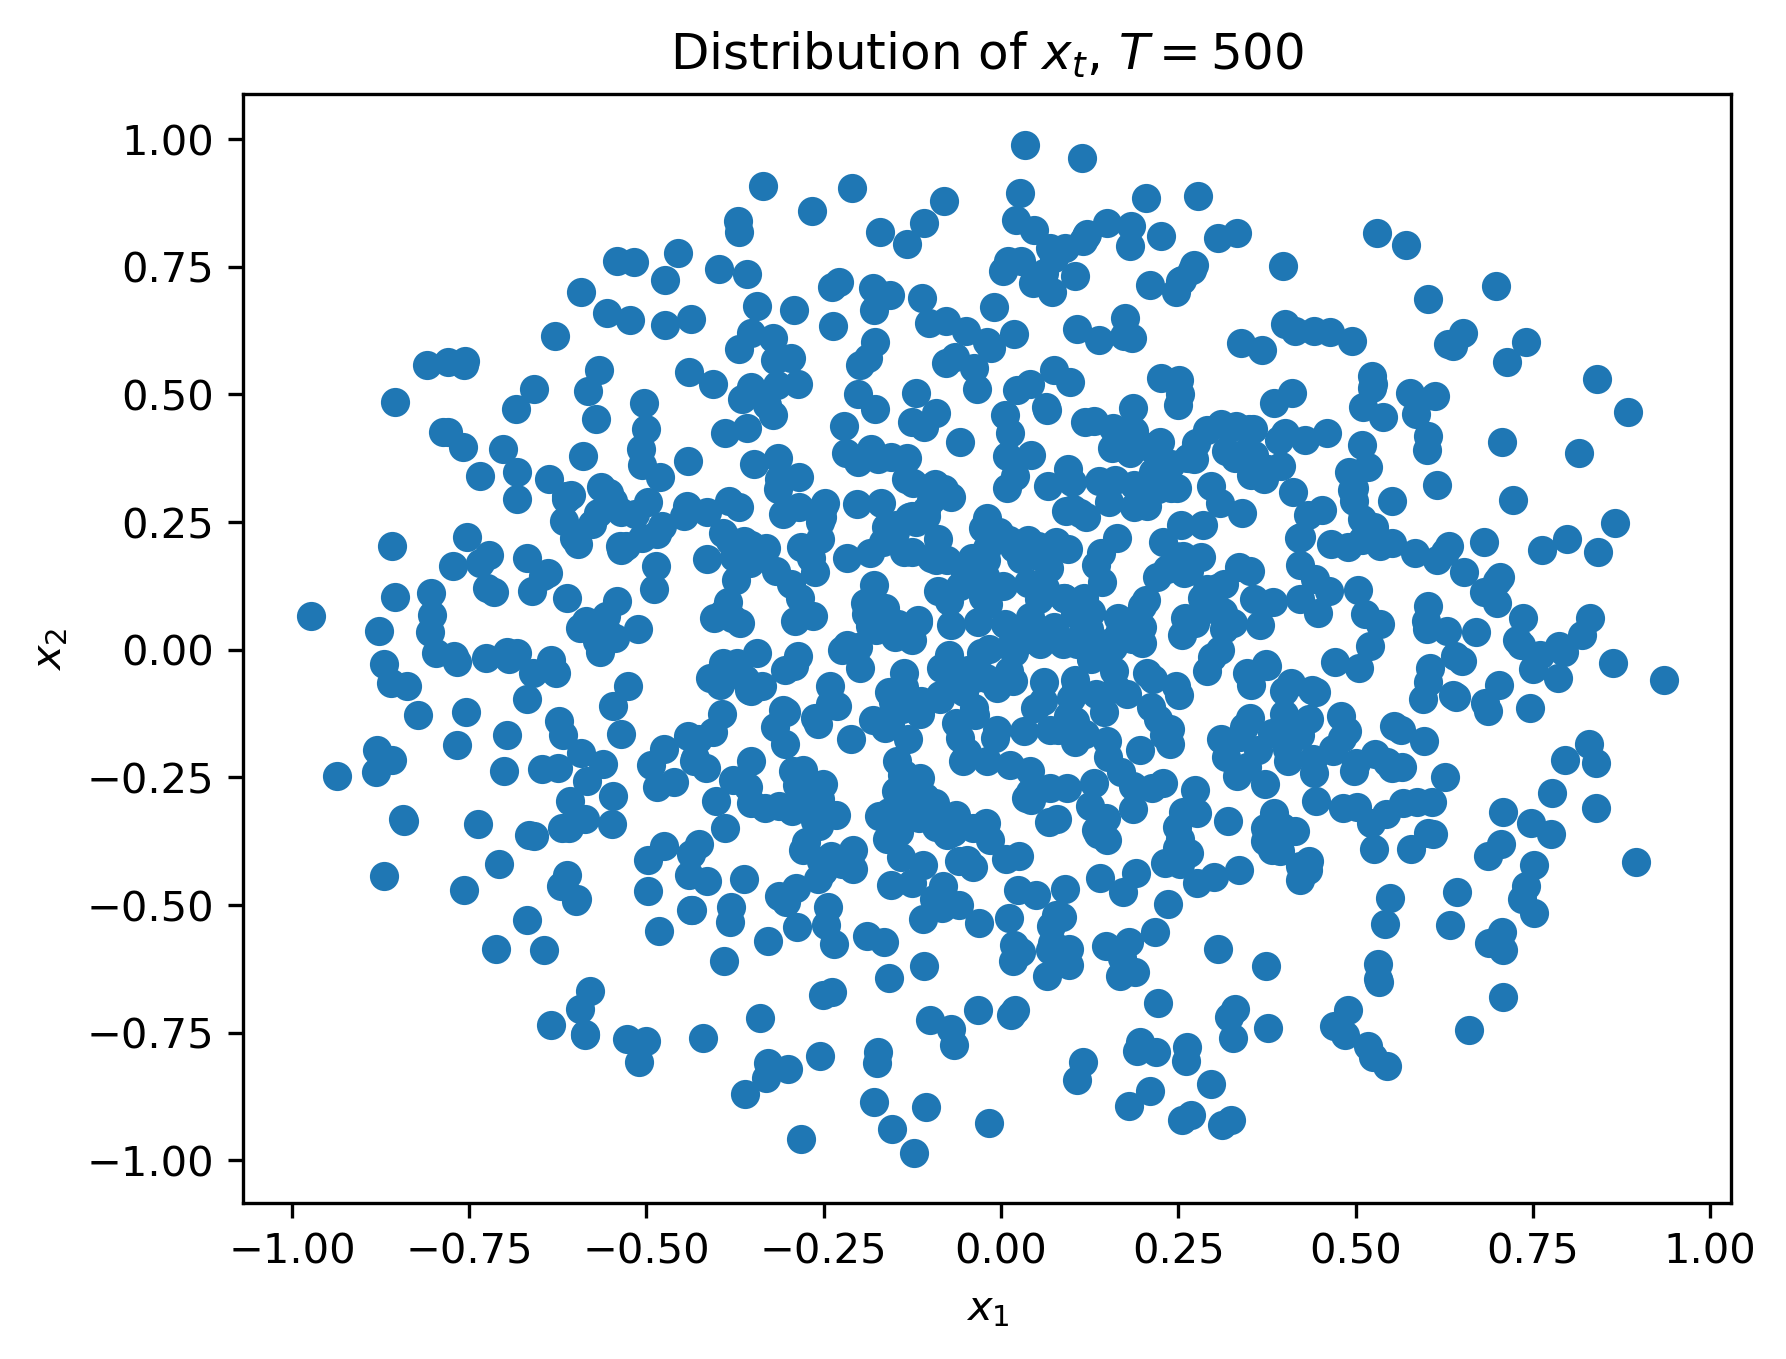

In [35]:
# generate the given series of functions
seq_length = 1000
dim = 2
samples = []
while len(samples) <= seq_length:
    sample = np.random.normal(loc=0,scale=0.5,size=dim)
    if np.linalg.norm(sample,ord=2) <= 1:
        samples.append(sample)
samples = np.array(samples)
plt.title(r"Distribution of $x_t$, $T=500$")
plt.scatter(samples[:,0], samples[:,1])
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

In [36]:
# generate a true underlying filter
w_true = np.array([0.3,1])
print(w_true)
ys = [2*int(w_true@x > 0)-1 for x in samples]

[0.3 1. ]


Text(0, 0.5, '$x_2$')

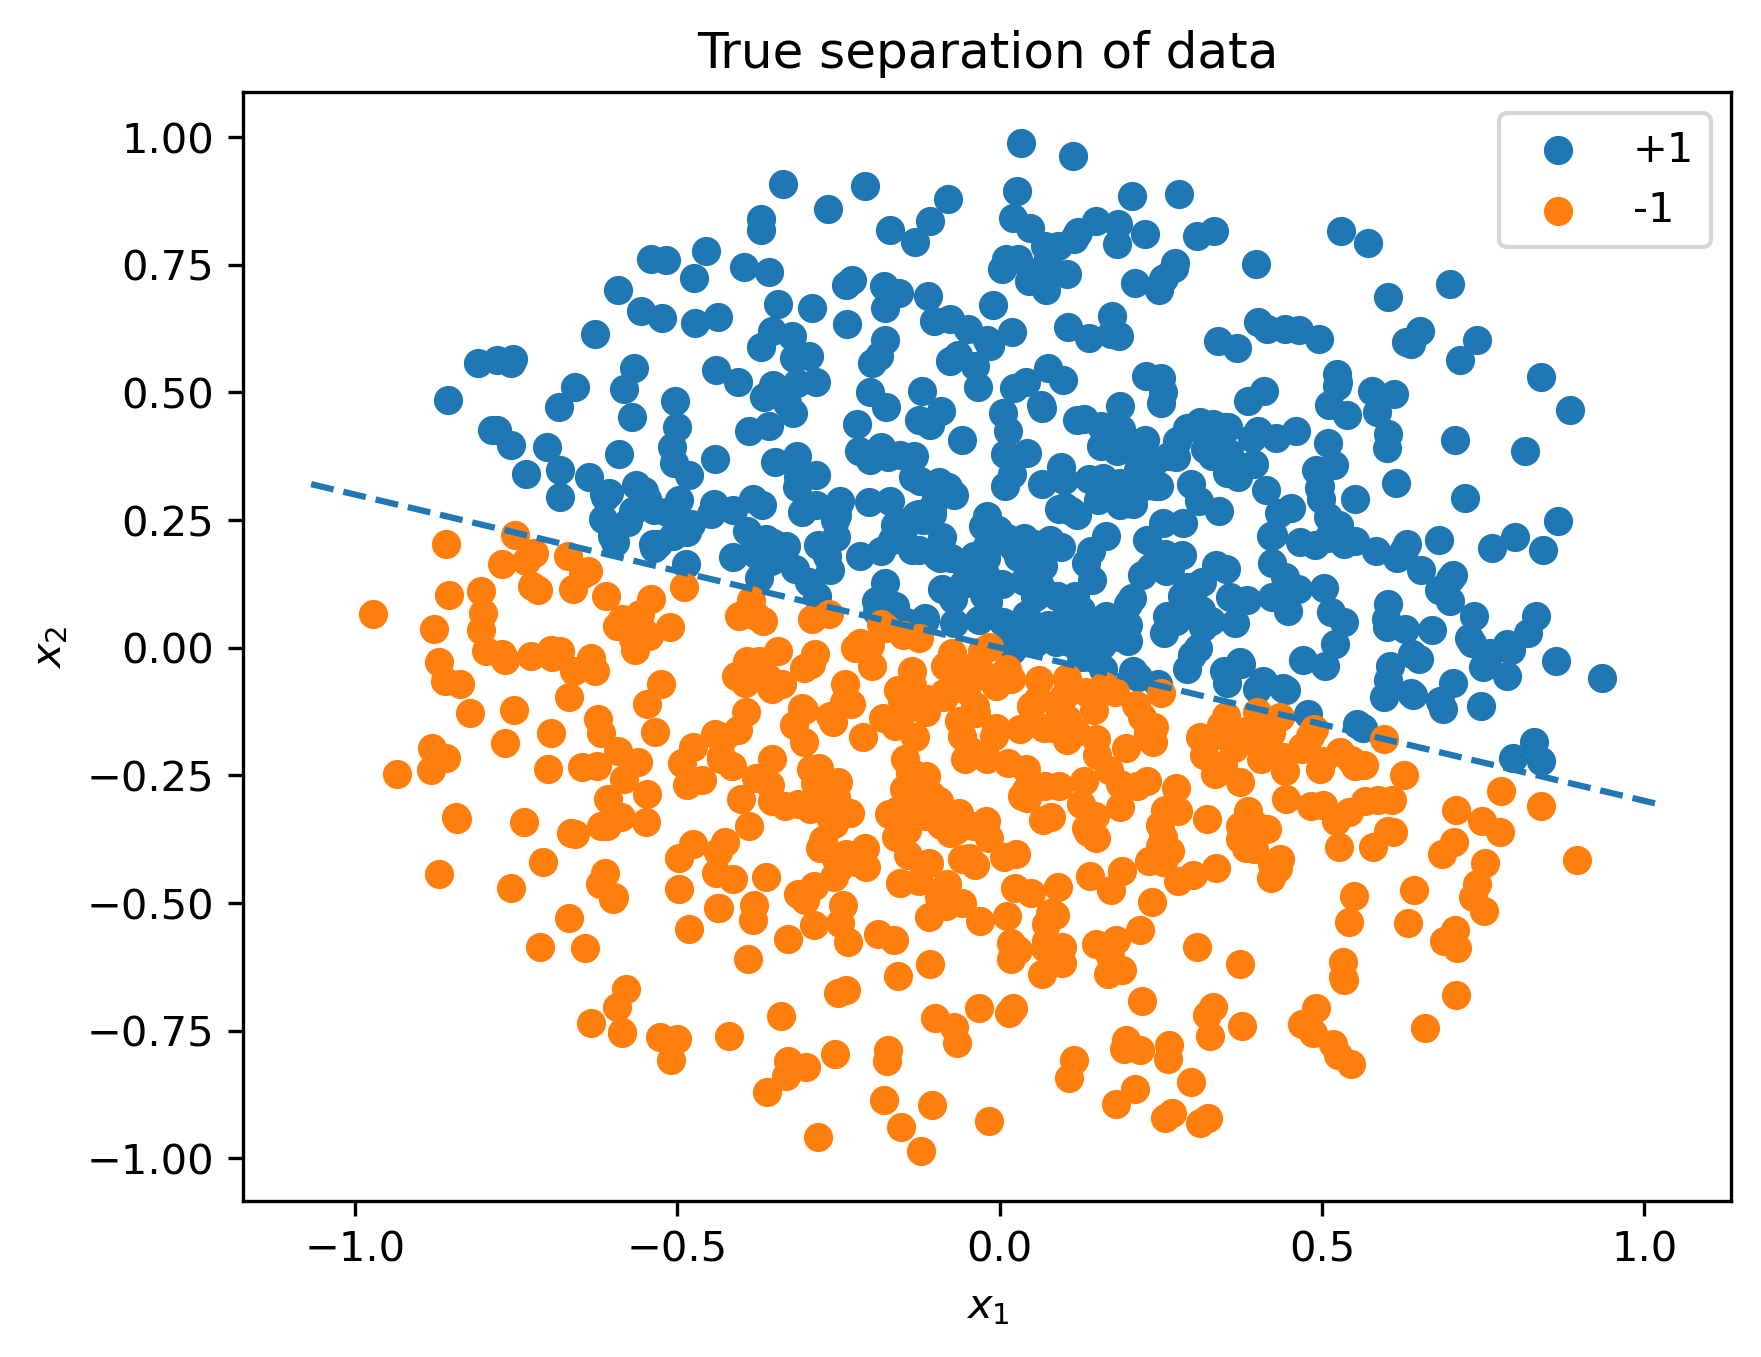

In [37]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
positive = np.array([x for i,x in enumerate(samples) if ys[i] == 1])
negative = np.array([x for i,x in enumerate(samples) if ys[i] == -1])

plt.title("True separation of data")
plt.scatter(positive[:,0], positive[:,1], label="+1")
plt.scatter(negative[:,0], negative[:,1], label="-1")
abline(-w_true[0]/w_true[1],0)
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

In [38]:
# solve the offline problem
def nll(w):
    return sum(np.log(1+np.exp(-y_i*w@sample_i)) for sample_i,y_i in zip(samples,ys))
def grad(w):
    return np.sum([(w @ sample_i - y_i)*sample_i for sample_i,y_i in zip(samples,ys)],axis=0)

In [39]:
result = minimize(
    fun = lambda w: nll(w),
    x0 = np.array([0,0]),
    constraints = [
        {
        'type':'ineq',
            'fun': lambda x: -np.linalg.norm(x) +1
        }
    ]
)
print(result)
offline_soln= result.x
np.linalg.norm(result.x)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 547.6434742339662
       x: [ 2.669e-01  9.637e-01]
     nit: 9
     jac: [-3.373e+01 -1.218e+02]
    nfev: 30
    njev: 9


1.0000000013096955

Text(0, 0.5, '$x_2$')

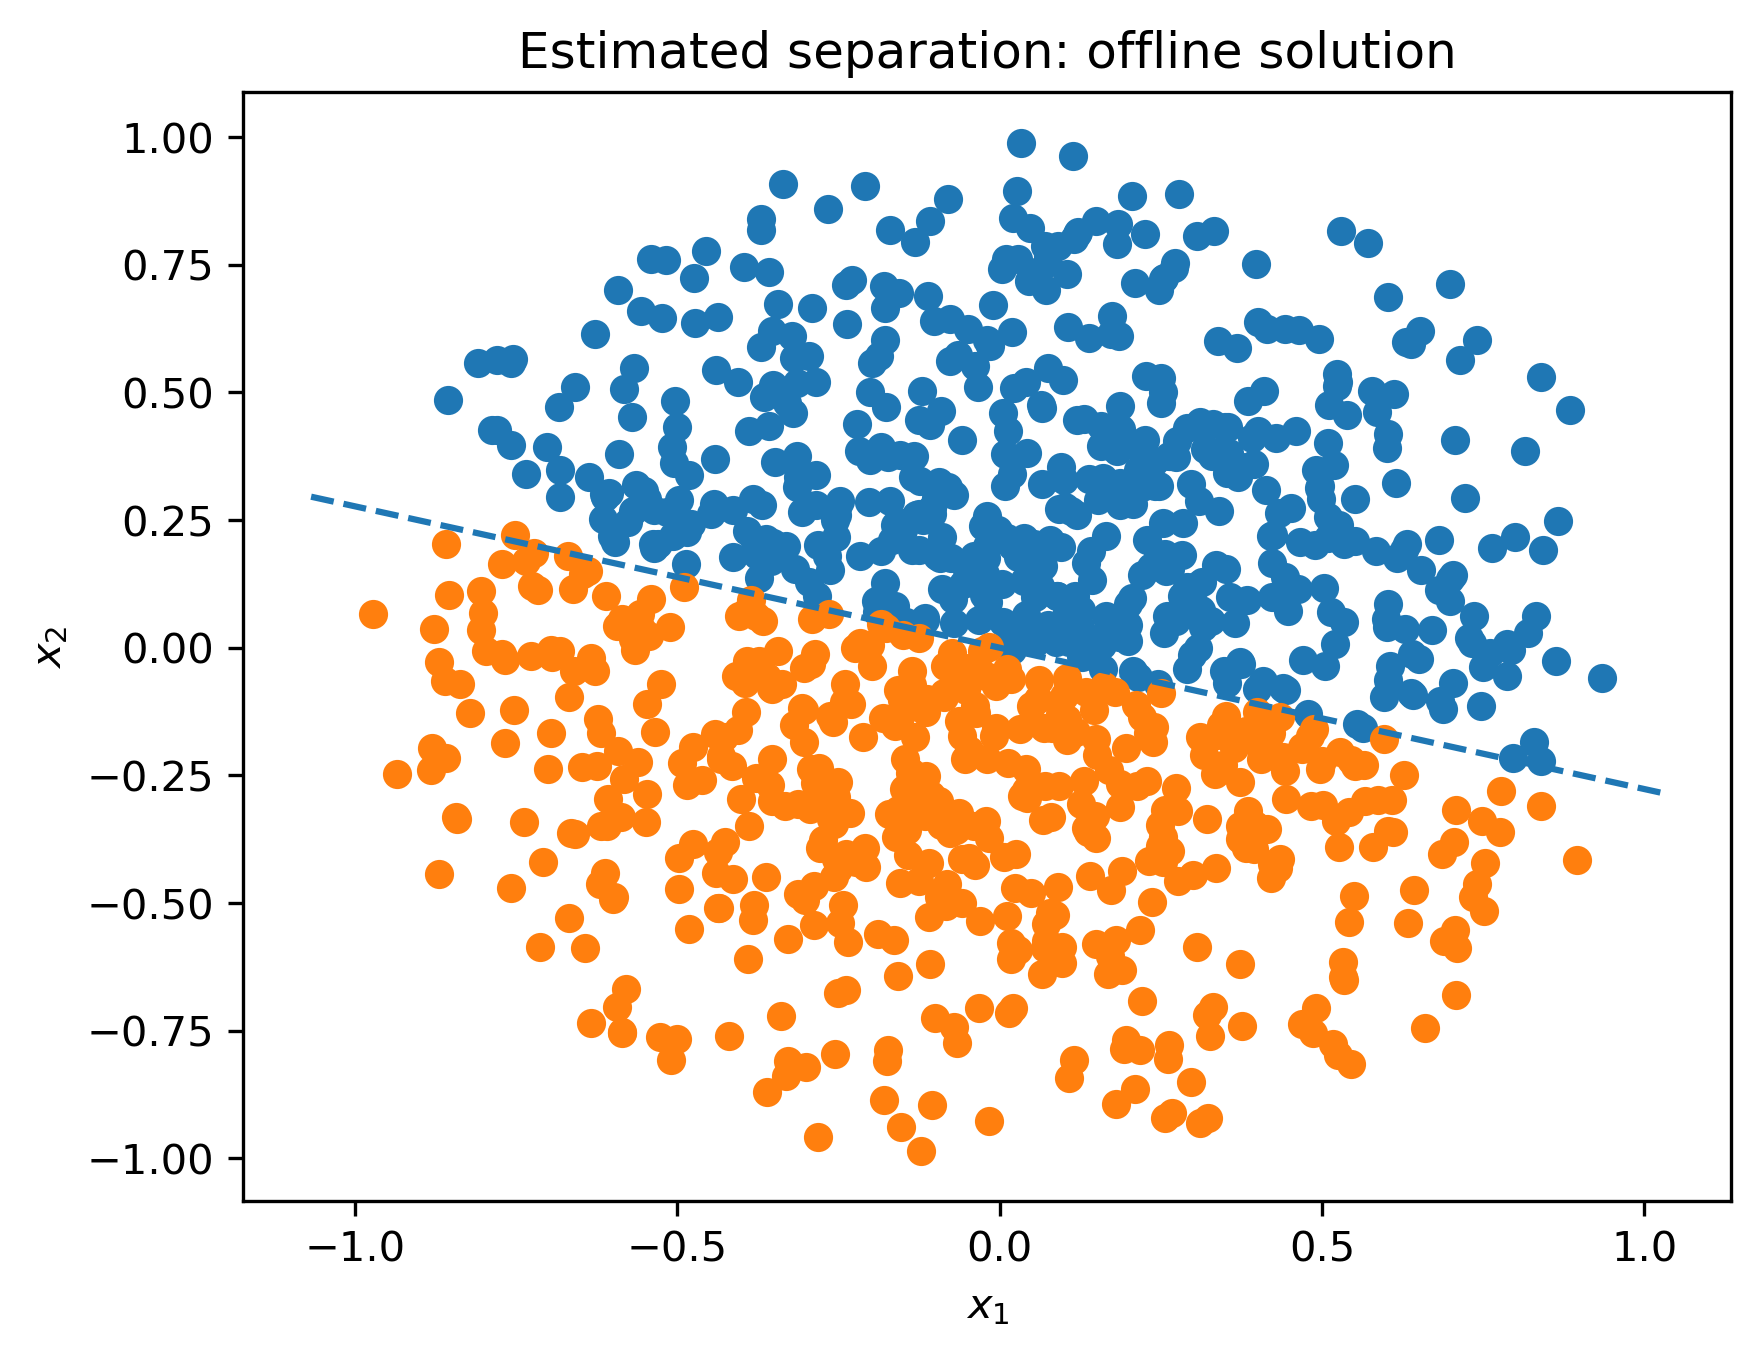

In [40]:
plt.title("Estimated separation: offline solution")
positive = np.array([x for i,x in enumerate(samples) if ys[i] == 1])
negative = np.array([x for i,x in enumerate(samples) if ys[i] == -1])
plt.scatter(positive[:,0], positive[:,1])
plt.scatter(negative[:,0], negative[:,1])
abline(-result.x[0]/result.x[1],0)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# online version

In [41]:
last_w = np.array([0,0])
loss_t = []
w_history = [last_w]
iter = 0
for x, y in zip(samples,ys):
    # predict
    last_w = w_history[-1]
    # suffer loss
    loss = np.log(1+np.exp(-y*last_w@x))
    loss_t.append(loss)
    # project it
    eta = 1/np.sqrt(iter+1)
    gradient = (-y*x)/(1+np.exp(-y*last_w@x))
    unproj_step = last_w - eta*gradient
    next_w = unproj_step / max(1,np.linalg.norm(unproj_step))
    w_history.append(next_w)

    predict = last_w@x

    iter+=1

In [42]:
offline_costs = [ np.log(1+np.exp(-y_i*offline_soln@sample_i)) for sample_i,y_i in zip(samples,ys)]
rolling_offline_costs = [sum(offline_costs[j] for j in range(i)) for i in range(len(offline_costs))]

In [43]:
# stuff for the bounds
F_norm = 1
grad_bound = 1
hess_bound = 2

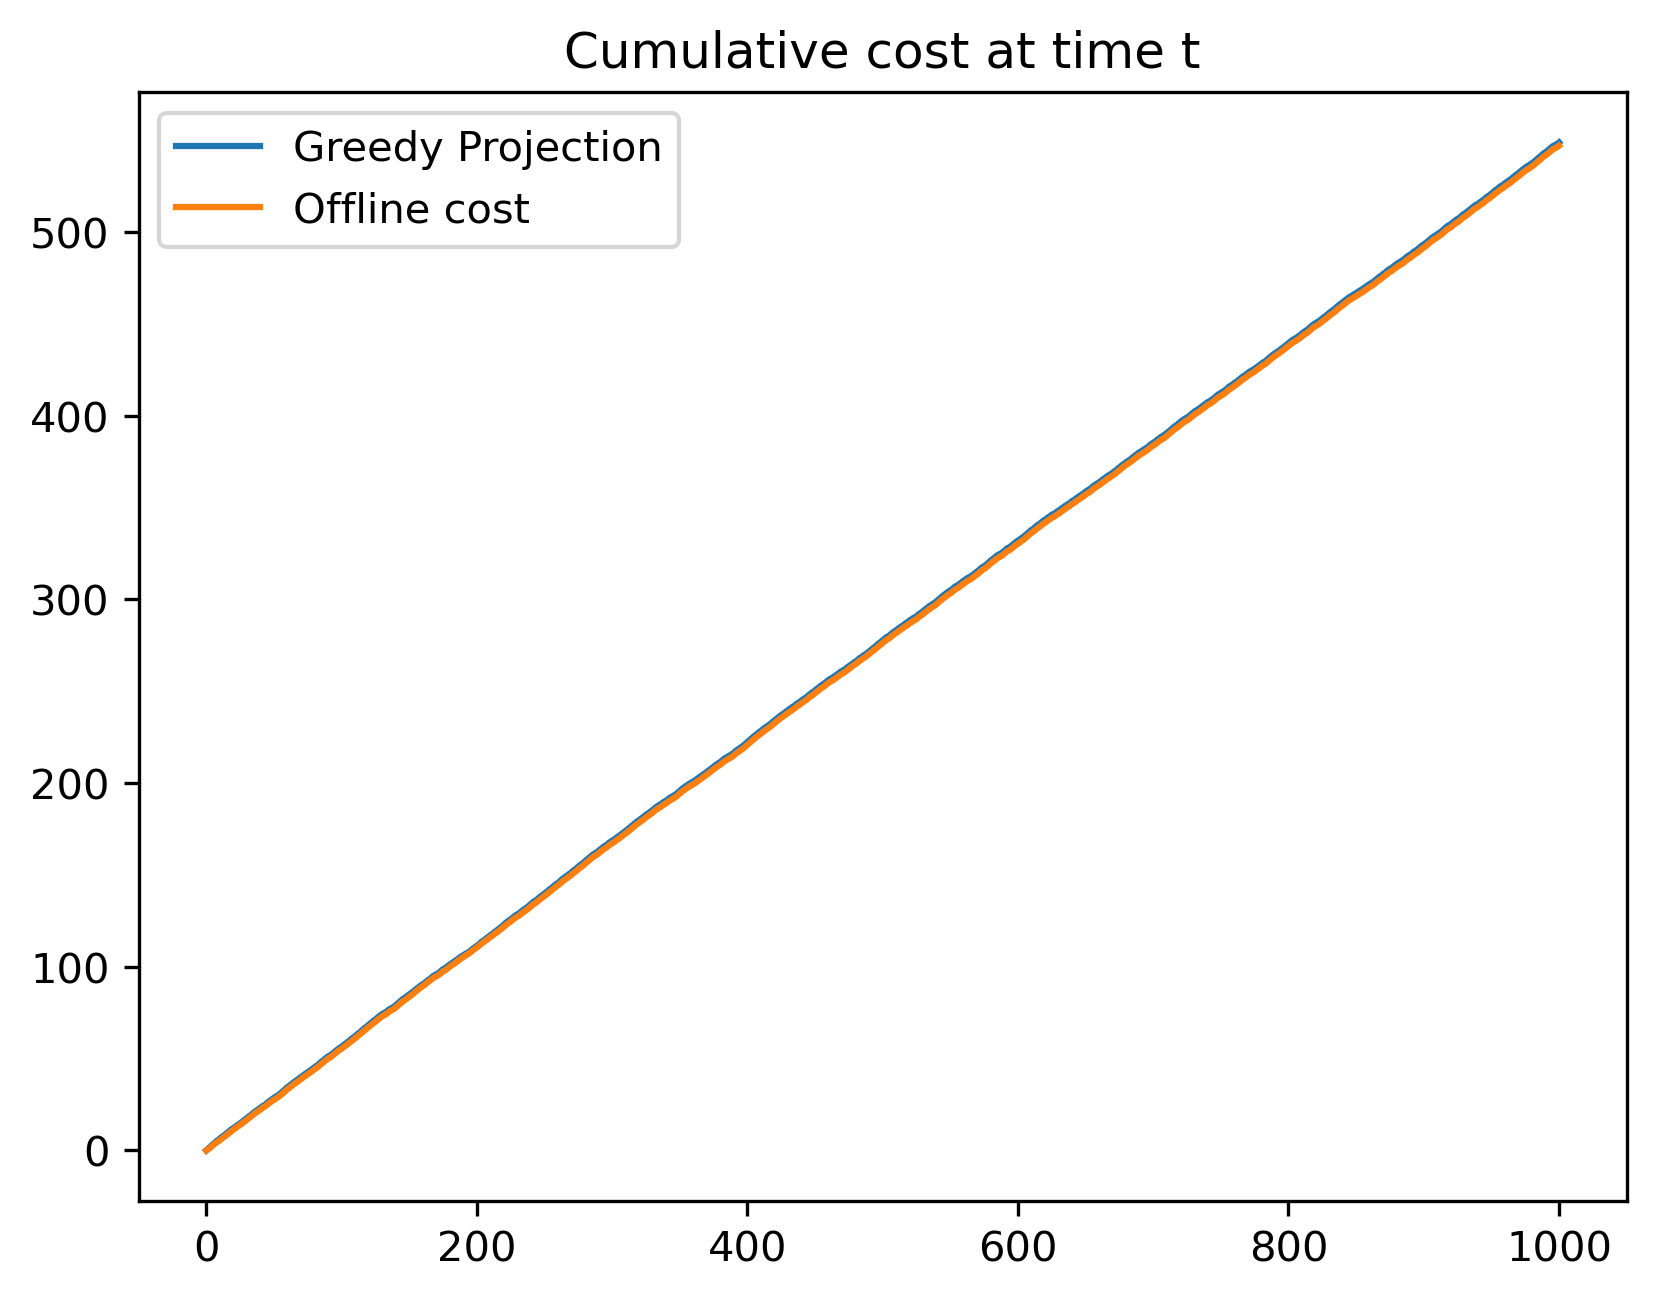

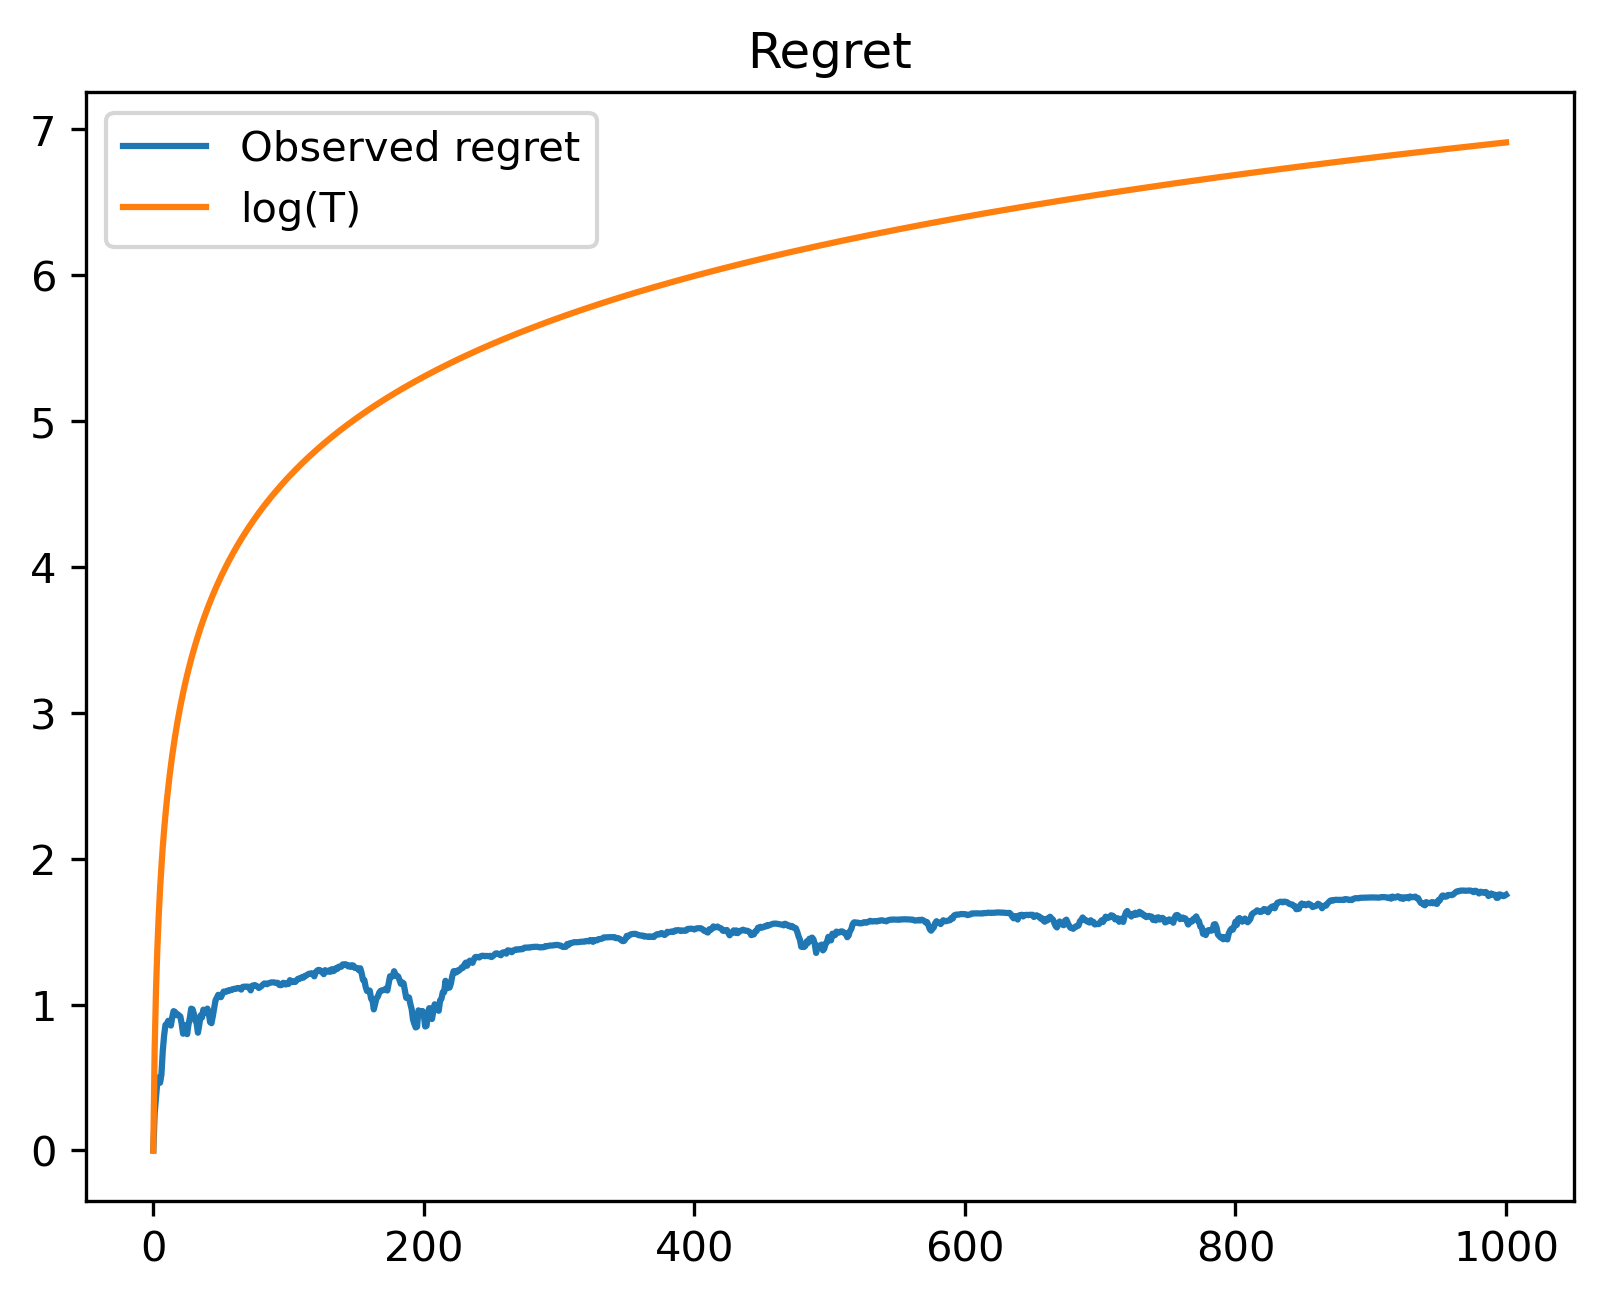

In [71]:
rolling_costs = [sum(loss_t[j] for j in range(i)) for i in range(len(loss_t))]
plt.title("Cumulative cost at time t")
plt.plot(rolling_costs, label="Greedy Projection")
plt.plot(rolling_offline_costs, label="Offline cost")
plt.legend()
plt.figure()
plt.title("Regret")
plt.plot(np.array(rolling_costs)-np.array(rolling_offline_costs),label="Observed regret")
T = np.arange(0,len(rolling_costs))
#plt.plot(T, ((F_norm**2)/2)*np.sqrt(T) + (np.sqrt(T)-0.5)*grad_bound**2, label="Theoretical bound (Zinkevich)")
plt.plot(np.log(T+1), label="log(T)")
plt.legend()

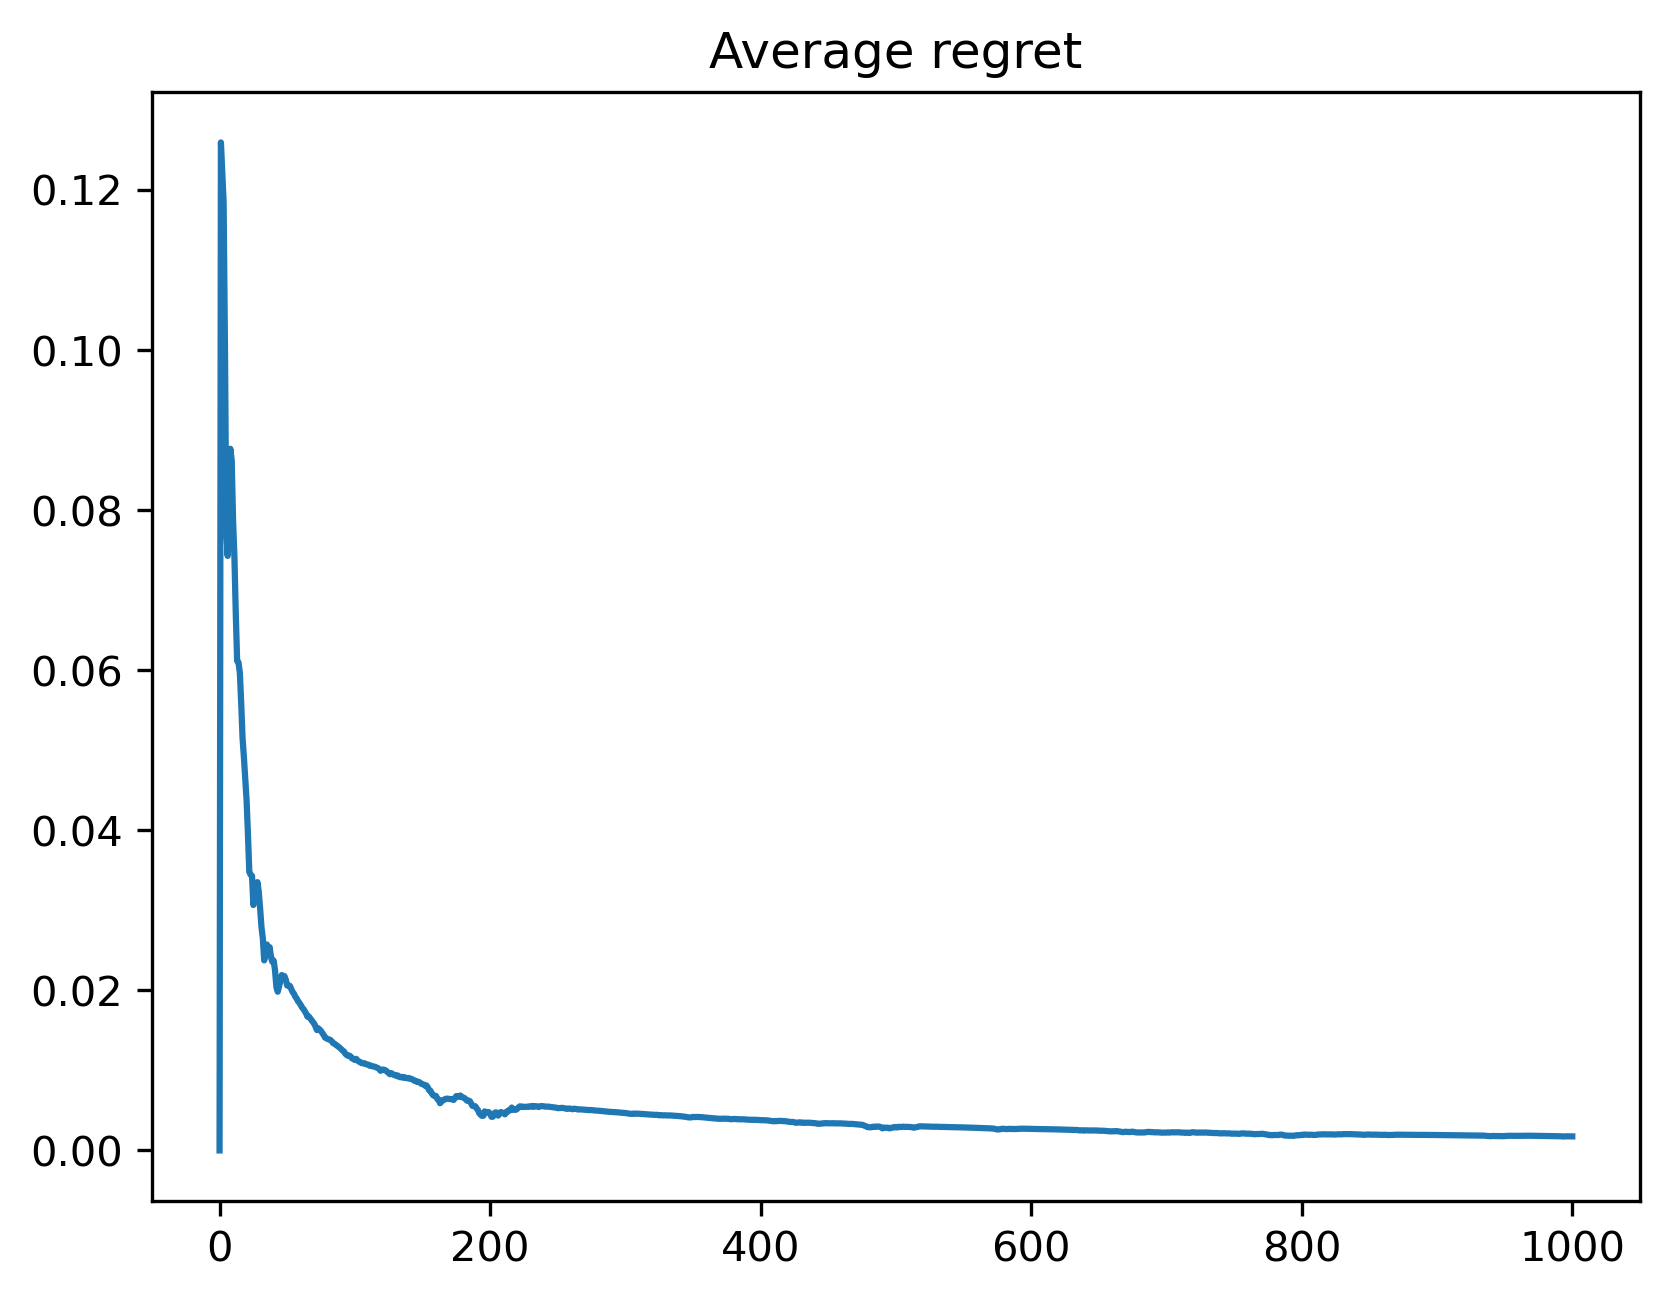

In [45]:
plt.title("Average regret")
plt.plot((np.array(rolling_costs)-np.array(rolling_offline_costs))/np.arange(1,seq_length+2))

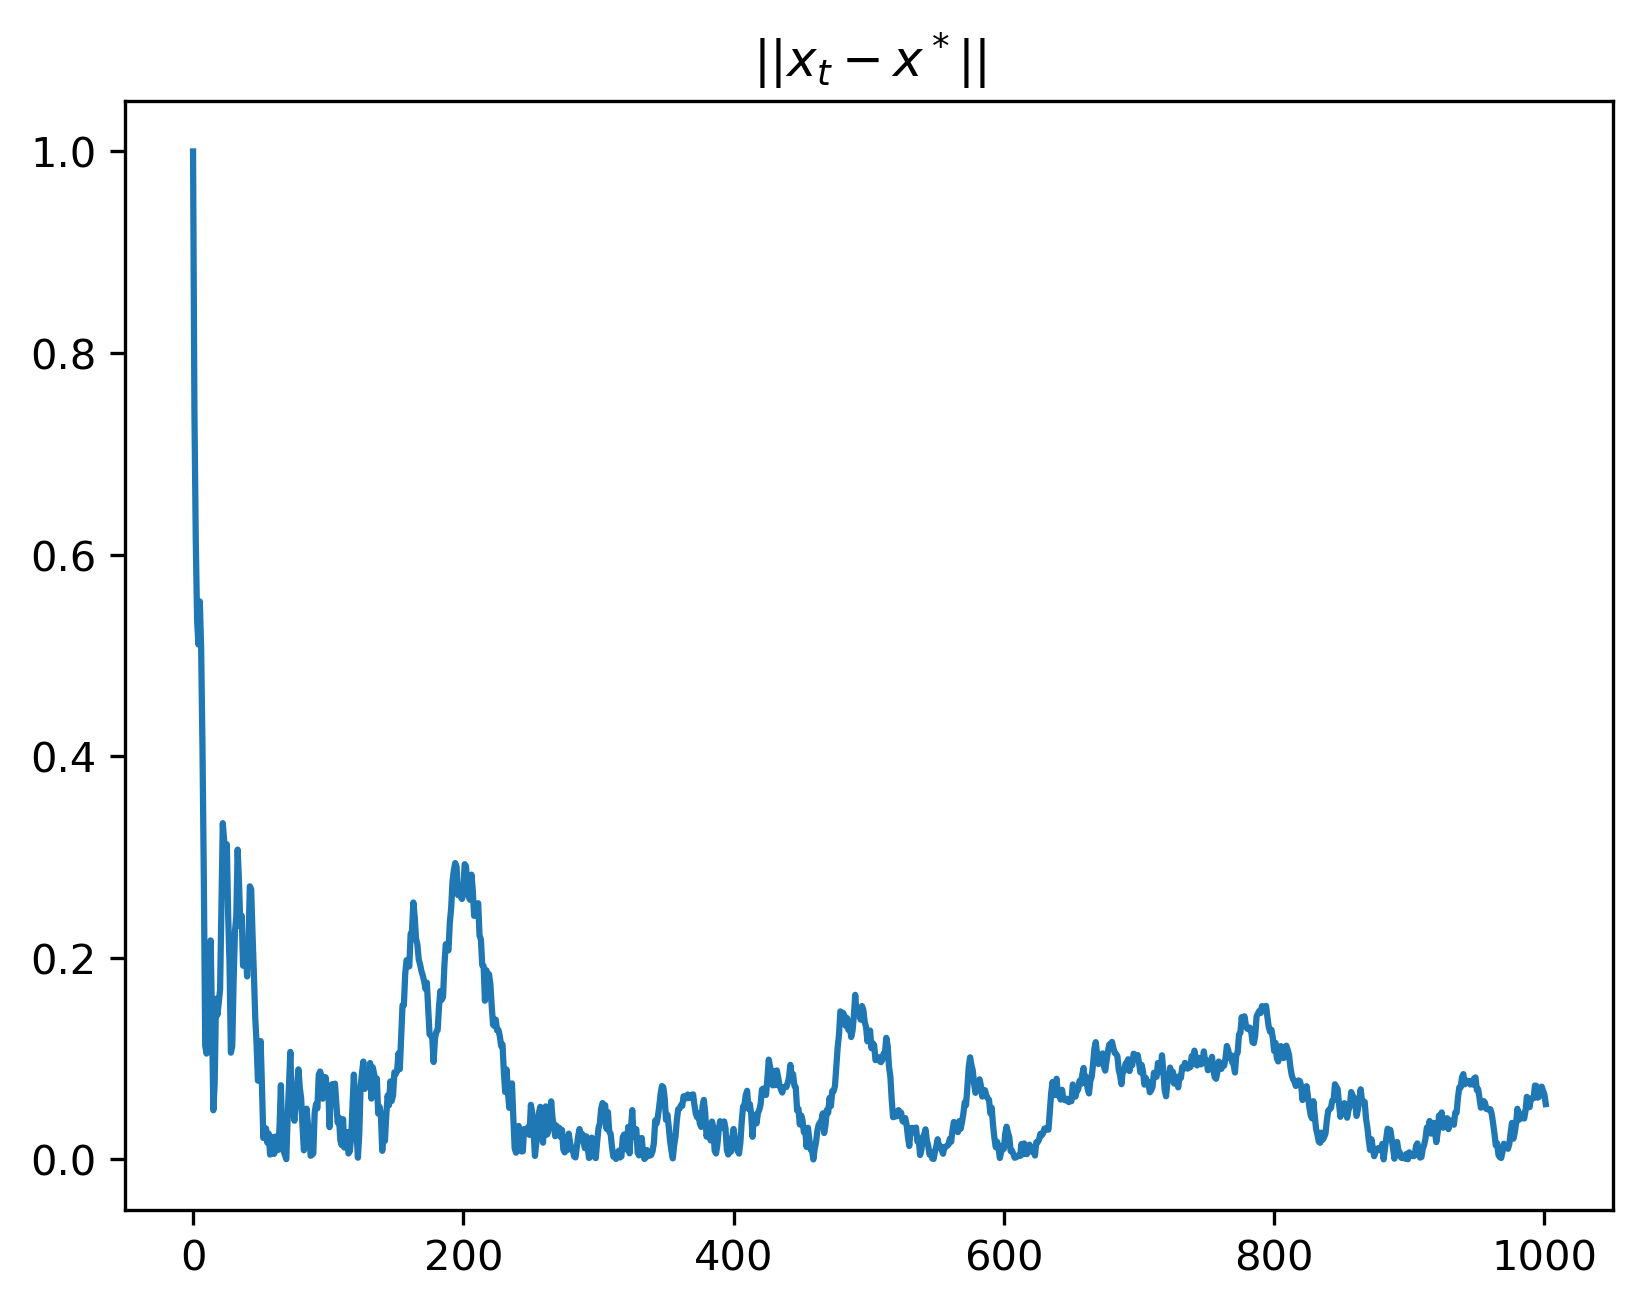

In [46]:
plt.title(r"$||x_t - x^*||$")
plt.plot([np.linalg.norm(w-offline_soln) for w in w_history])

In [53]:
[np.outer(x,x) for x in samples]

[array([[0.37477644, 0.27038343],
        [0.27038343, 0.19506882]]),
 array([[0.07562532, 0.1037401 ],
        [0.1037401 , 0.14230697]]),
 array([[ 0.24740234, -0.11775457],
        [-0.11775457,  0.05604692]]),
 array([[0.09442993, 0.03629339],
        [0.03629339, 0.01394908]]),
 array([[ 0.1593428 , -0.03220479],
        [-0.03220479,  0.00650892]]),
 array([[ 9.93722630e-06, -7.27700232e-04],
        [-7.27700232e-04,  5.32892794e-02]]),
 array([[ 0.57531685, -0.30102776],
        [-0.30102776,  0.15750922]]),
 array([[ 0.05596844, -0.14994616],
        [-0.14994616,  0.40172373]]),
 array([[0.00439262, 0.05130669],
        [0.05130669, 0.59927321]]),
 array([[ 0.01716332, -0.00515451],
        [-0.00515451,  0.00154801]]),
 array([[ 0.49821687, -0.39044554],
        [-0.39044554,  0.30598666]]),
 array([[ 0.09601454, -0.05447299],
        [-0.05447299,  0.03090476]]),
 array([[ 0.03684245, -0.15103936],
        [-0.15103936,  0.61920118]]),
 array([[ 3.15025765e-01, -7.96388876e

In [63]:
[np.linalg.eig(np.outer(x,x)) for x in samples[0:4]]

[(array([ 5.69845261e-01, -5.55111512e-17]),
  array([[ 0.81097538, -0.58508028],
         [ 0.58508028,  0.81097538]])),
 (array([-2.77555756e-17,  2.17932282e-01]),
  array([[-0.80807617, -0.58907802],
         [ 0.58907802, -0.80807617]])),
 (array([3.03449252e-01, 6.93889390e-18]),
  array([[ 0.90293994,  0.42976676],
         [-0.42976676,  0.90293994]])),
 (array([0.10837901, 0.        ]),
  array([[ 0.93343107, -0.35875679],
         [ 0.35875679,  0.93343107]]))]

In [52]:
np.linalg.eig(np.sum([np.outer(x,x) for x in samples],axis=0))

(array([165.1431801 , 168.63411784]),
 array([[-0.82140914,  0.57033939],
        [-0.57033939, -0.82140914]]))

In [66]:
(1/len(samples))*np.sum([np.outer(x,x) for x in samples],axis=0)

array([[ 0.16611262, -0.00163381],
       [-0.00163381,  0.16733123]])